In [7]:
from smitebuilder.etl import get_matchdata, extract_performance_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [9]:
raw_data = get_matchdata('P:/SmiteData/conquest_match_data/1649.json')
data = extract_performance_data(raw_data)

In [10]:
two_d = TSNE().fit_transform(data)

No handles with labels found to put in legend.


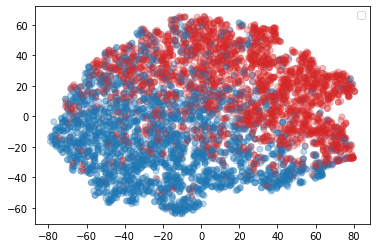

In [20]:
x = [x[0] for x in two_d]
y = [y[1] for y in two_d]
c = ['tab:blue' if e['win_status'] == 'Winner' else 'tab:red' for e in raw_data]
plt.scatter(x,y, c=c, alpha=0.3)
plt.legend()
plt.show()